In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

## Modeling functions

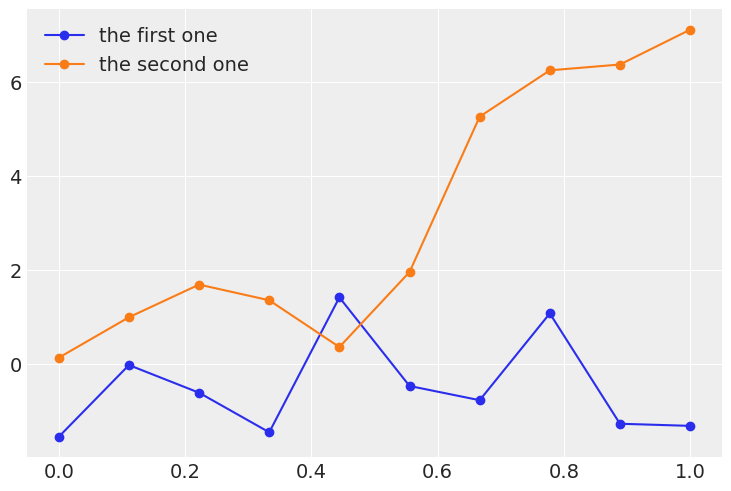

In [3]:
np.random.seed(50)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x)) # location, scale, size 순서
plt.plot(x, y, 'o-', label = 'the first one')
y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label = 'the second one')

plt.legend()

Gaussian Process를 할 랜덤값들 생성  
firrst one은 아예 독립적이고, second one은 어느정도 dependency를 가지고 있다.  
y[i+1]를 샘플링 하기 위한 분포의 mean이 y[i]이다.

np.random.multivariate_normal()을 이용하여 똑같이 값을 샘플링 가능한데, 순서대로 mean과 covariance 행렬을 parameter로 전달해주면 된다.

## Covariance functions and kernels

In [4]:
def exp_quad_kernel(x, knots, ℓ = 1):
    """Gaussian kernel"""
    return np.array([np.exp(-(x-k)**2/(2*ℓ**2)) for k in knots])

$K(x, x') = exp(-|x-x'|^2/2l^2)$ 를 구현하였고, 만약 x 와 x'가 같을 경우 1을 반환하여 두 데이터들 사이의 유사도 비교가능  
(여기서 $l$은 scale로 가우시안 분포의 폭을 결정)

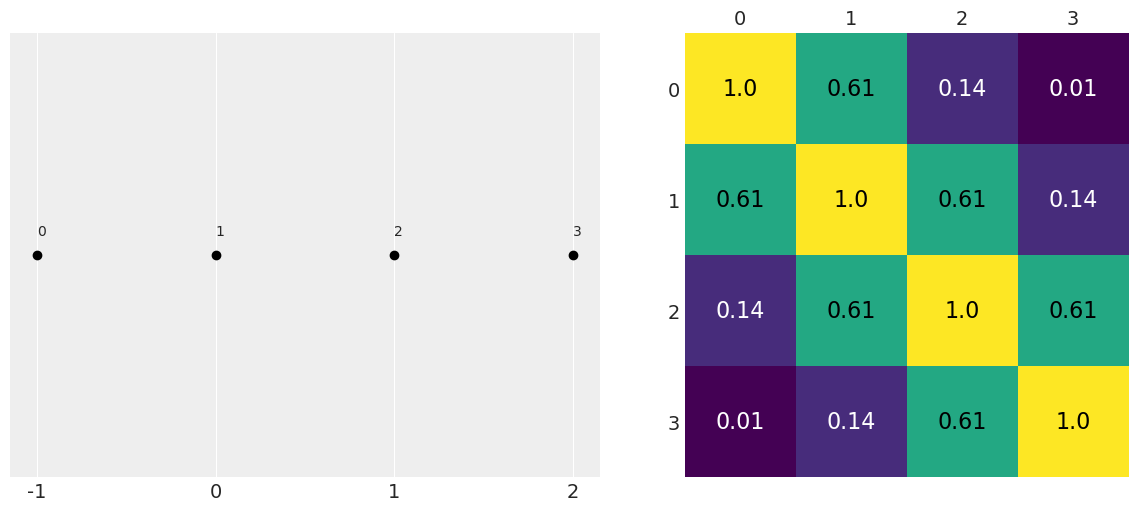

In [5]:
data = np.array([-1, 0, 1, 2])
cov = exp_quad_kernel(data, data, 1) # data 배열의 cov tensor 반환

_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False) # 그리드 생성
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                  color = colors[int(im.norm(cov[i, j]) > 0.5)],
                  ha = 'center', va = 'center', fontdict = {'size' : 16})
# 가우시안 커널을 적용한 유사도 출력. 값이 1에 가까울수록 유사함.
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

밝을수록 큰 공분산을 가지는 것을 의미하고, 서로 값들이 멀어질수록 공분산 값도 작아진다.

Text(-0.03, 0.5, 'f(x)')

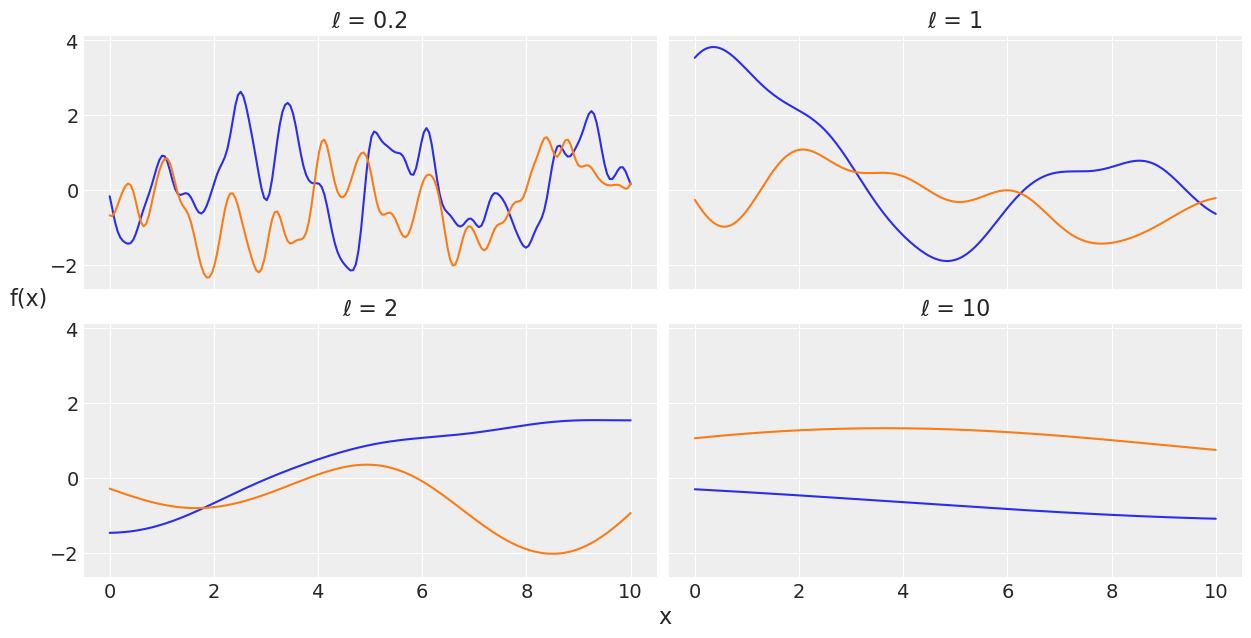

In [6]:
np.random.seed(234)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize = (12, 6), sharex=True,
                      sharey=True, constrained_layout = True)

ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ = {ℓ}')
    
fig.text(0.51, -0.03, 'x', fontsize = 16)
fig.text(-0.03, 0.5, 'f(x)', fontsize = 16)

l이 커짐에 따라 커널에 들어가는 값은 작게 되고, 따라서 분포 자체는 더 부드러워진다.  
(l은 표준편차이고, l이 커지면 분자 값이 어느 값이든 값은 어느정도 작아질거여서 분포가 좀 robust 해진다.)

## Gaussian Process Regression

Text(0, 0.5, 'f(x)')

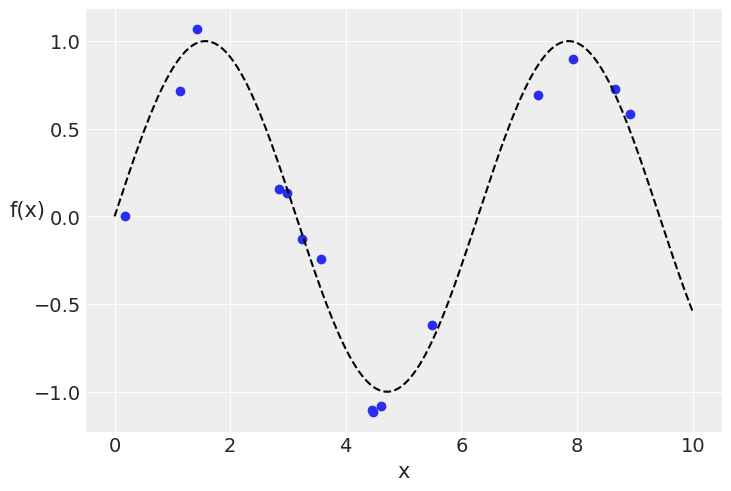

In [7]:
np.random.seed(48)
x = np.random.uniform(0, 10, size = 15)
y = np.random.normal(np.sin(x), 0.1) # mean_function 이 sine 함수고, epsilon이 0.1
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation = 0)

In [8]:
X = x[:, None]

with pm.Model() as model_reg:
    """Gamma-Normal Distribution은 
    Unknown mean and precision인 Normal Distribution에 대해 conjugate prior다.
    """
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # Gaussian Kernel 계산
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    """Gaussian process의 Prior 설정
    정규분포가 아니라 Gaussian Process를 통해 Data를 fitting 하면서 샘플링"""
    gp = pm.gp.Marginal(cov_func=cov)
    # Prior 설정
    ϵ = pm.HalfNormal('ϵ', 25)
     # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    idata_reg = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'ℓ'}>,
        <AxesSubplot:title={'center':'ℓ'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

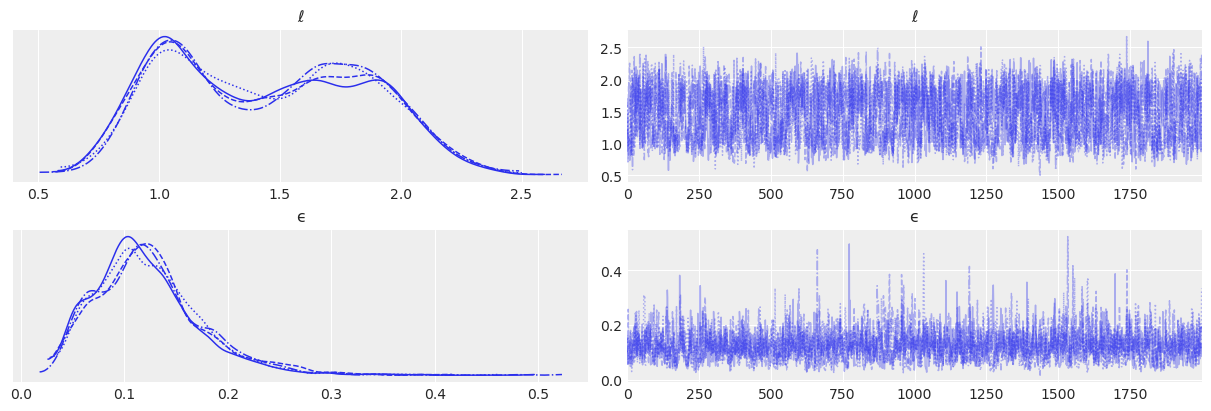

In [9]:
az.plot_trace(idata_reg)

In [10]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:, None]
# np.ceil은 올림함수
# Gaussian Process를 이용하여 생성된 x

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [11]:
with model_reg:
    preds_sample = pm.sample_posterior_predictive(idata_reg, var_names=['f_pred'], samples = 100)

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0.5, 0, 'X')

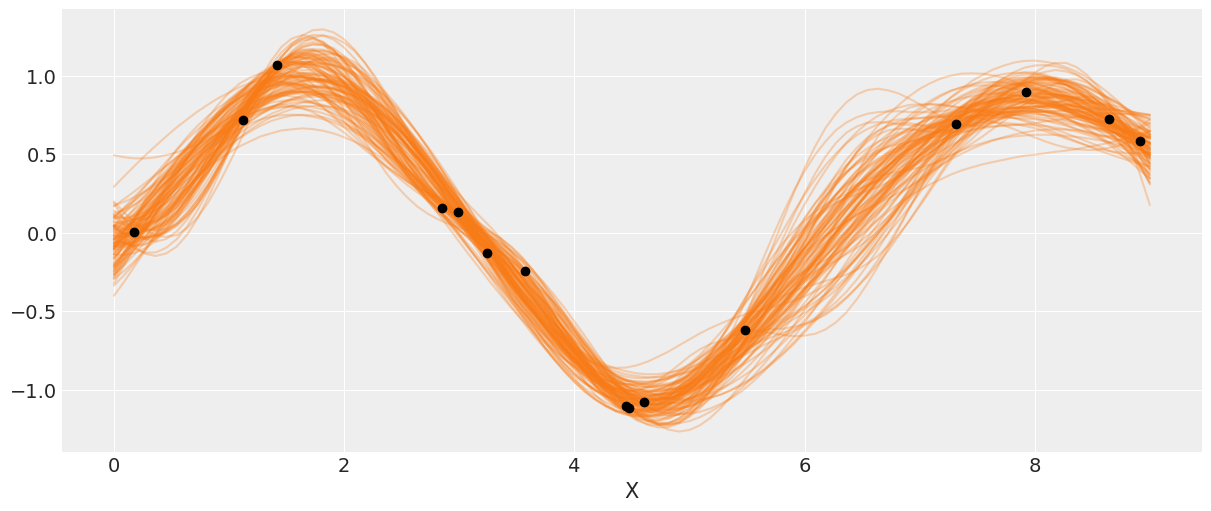

In [12]:
_, ax = plt.subplots(figsize = (12, 5))
ax.plot(X_new, preds_sample['f_pred'].T, 'C1-', alpha = 0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Text(0, 0.5, 'f(x)')

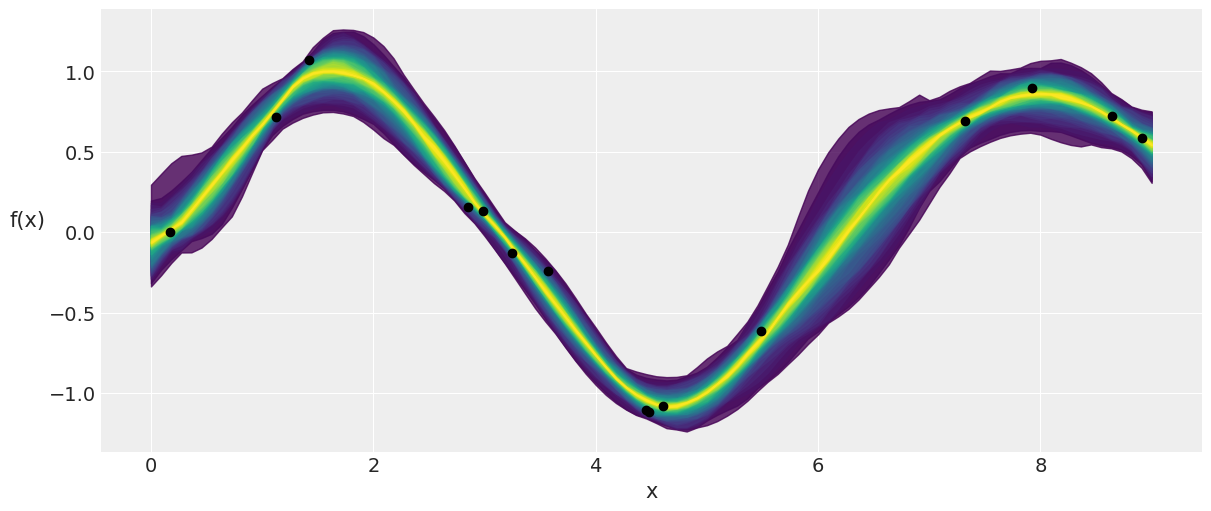

In [13]:
_, ax = plt.subplots(figsize = (12, 5))

pm.gp.util.plot_gp_dist(ax, preds_sample['f_pred'], X_new, palette='viridis', plot_samples = False)

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation = 0, labelpad=15)

Text(0.5, 0, 'X')

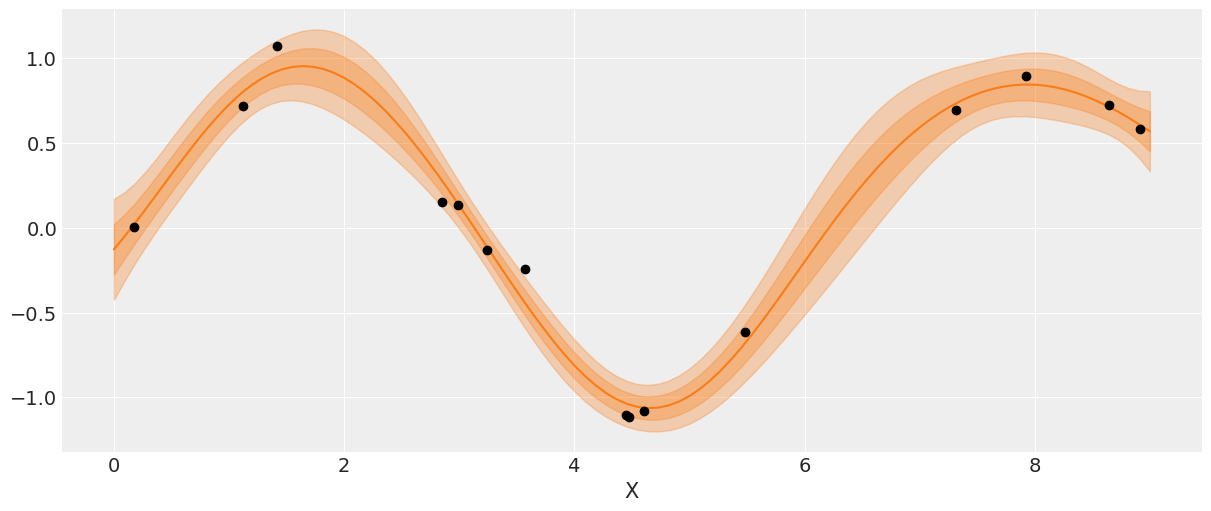

In [14]:
_, ax = plt.subplots(figsize = (12, 5))

# 새로운 값 예측
point = {'ℓ' : idata_reg.posterior['ℓ'].mean(), 'ϵ' : idata_reg.posterior['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# mean과 1 표준편차, 2표준편차 벗어난 거 그리기
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(), 
               mu - sd, mu + sd,
               color = 'C1', alpha = 0.3)
ax.fill_between(X_new.flatten(), 
               mu - 2*sd, mu + 2*sd,
               color = 'C1', alpha = 0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')

## Regression with spatial autocorrelation

In [15]:
island_dist = pd.read_csv('data/islands_dist.csv', sep=',', index_col=0)
island_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [16]:
islands = pd.read_csv('data/islands.csv', sep=',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [17]:
island_dist_sqr = island_dist.values**2
culutre_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [18]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov) # Gaussian Process를 이용하는 코드
    f = gp.prior('f', X=island_dist_sqr)
    # gaussian prior에서 island_dist_sqr을 이용하여 x 봅아내기.
    
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    
    idata_islands = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=1)

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\gp\cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α, f_rotated_, ℓ, η]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 139 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


pickle 라이브러리 관련 오류가 나오면 cores = 1 지정

In [19]:
az.summary(idata_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.927,1.203,-1.339,3.007,0.064,0.045,375.0,387.0,1.00
β,0.281,0.127,0.049,0.515,0.007,0.006,346.0,360.0,1.00
η,0.268,0.334,0.003,0.725,0.016,0.011,434.0,639.0,1.01
ℓ,1.022,2.285,0.000,3.833,0.190,0.135,141.0,134.0,1.00
f[0],-0.139,0.363,-0.773,0.548,0.014,0.010,655.0,392.0,1.01
f[1],-0.029,0.328,-0.684,0.529,0.012,0.010,715.0,543.0,1.00
f[2],-0.026,0.298,-0.603,0.515,0.010,0.009,851.0,541.0,1.00
f[3],0.373,0.266,-0.099,0.860,0.009,0.007,887.0,721.0,1.00
f[4],0.060,0.247,-0.382,0.537,0.008,0.007,1036.0,780.0,1.00
f[5],-0.304,0.281,-0.820,0.227,0.011,0.008,653.0,483.0,1.00


Text(0, 0.5, 'covariance')

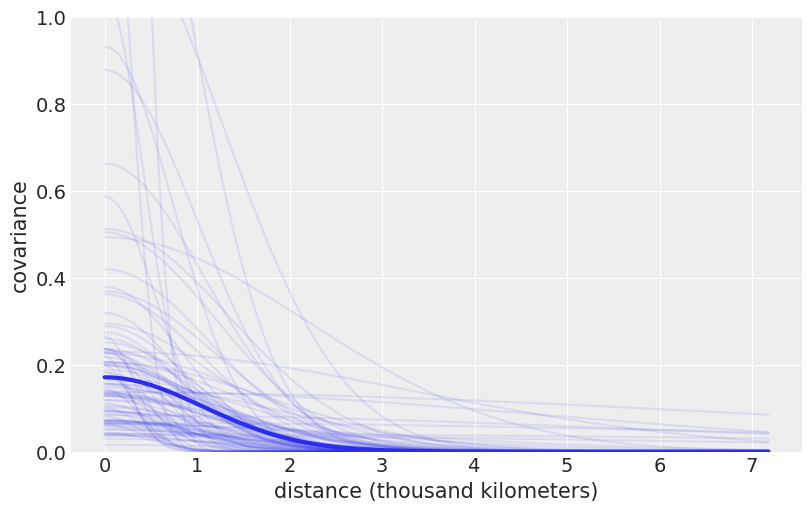

In [20]:
posterior_islands = idata_islands.posterior.stack(samples = ('chain', 'draw'))
trace_η = posterior_islands['η'].values
trace_ℓ = posterior_islands['ℓ'].values

_, ax = plt.subplots(1, 1, figsize = (8, 5))
xrange = np.linspace(0, island_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [21]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * island_dist_sqr))

# convert to correlation matrix
"""수학적으로 Cov 행렬을 Corr 행렬로 바꾸는 건 Cov 행렬에 대해 대각화 문제를 푼뒤
root를 취해준다음 그 행렬을 고유벡터 행렬로 여겨서 고유값을 구하면 된다.
cf : https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix"""
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post # numpy에서 행렬 곱 연산자
ρ = pd.DataFrame(ρ, index=island_dist.columns, columns=island_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.90,0.84,0.00,0.51,0.16,0.01,0.03,0.22,0.0
Ti,0.90,1.00,0.96,0.00,0.51,0.17,0.03,0.04,0.18,0.0
SC,0.84,0.96,1.00,0.00,0.34,0.27,0.05,0.09,0.10,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.07,0.34,0.31,0.00,0.0
Fi,0.51,0.51,0.34,0.00,1.00,0.01,0.00,0.00,0.77,0.0
Tr,0.16,0.17,0.27,0.07,0.01,1.00,0.24,0.73,0.00,0.0
Ch,0.01,0.03,0.05,0.34,0.00,0.24,1.00,0.52,0.00,0.0
Mn,0.03,0.04,0.09,0.31,0.00,0.73,0.52,1.00,0.00,0.0
To,0.22,0.18,0.10,0.00,0.77,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


(10.0, 73.0)

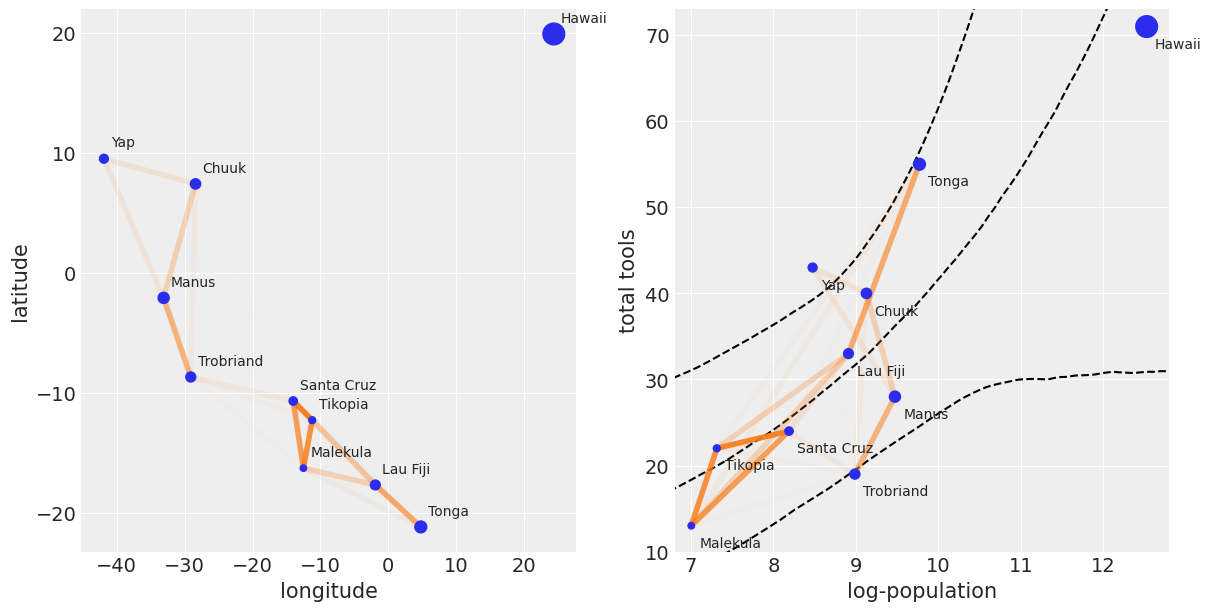

In [22]:
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(posterior_islands['α'].values[:, None] +
                     posterior_islands['β'].values[:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culutre_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i] + 1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)
    
ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})

for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        
# 두 지점 간의 상대적인 유사도를 표시하는데, 상관계수가 클 수록 진하게 표시
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)

## Gaussian process classification

In [23]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [24]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [25]:
with pm.Model() as model_iris:
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(1000, return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 83 seconds.


In [26]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    # X_new를 이용한 conditional 분포 생성
    preds_sample = pm.sample_posterior_predictive(idata_iris, var_names=['f_pred'], samples = 1000)

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [27]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'θ')

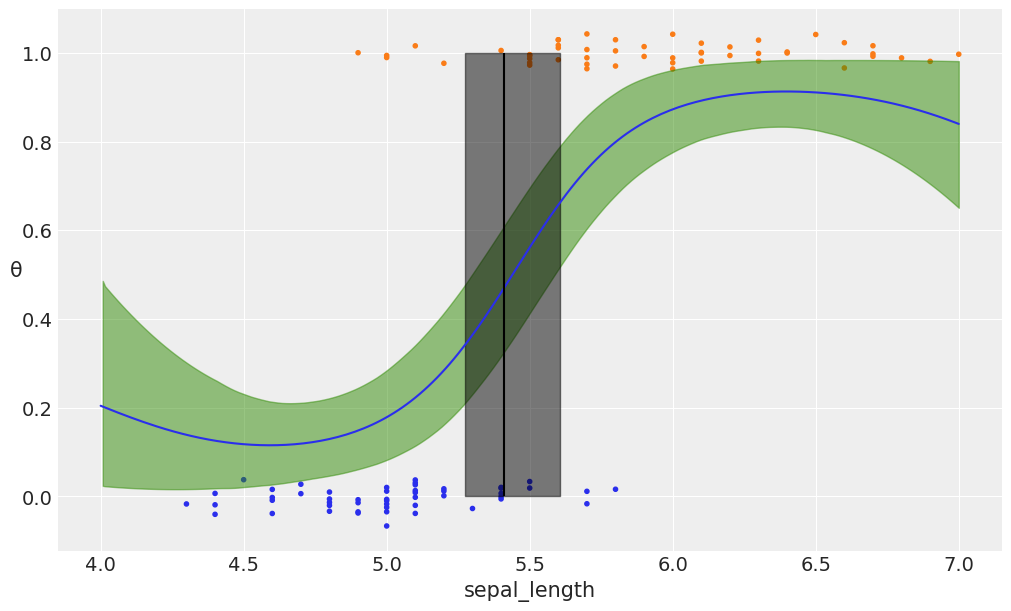

In [28]:
_, ax = plt.subplots(figsize = (10, 6))

fp = logistic(preds_sample['f_pred'])
fp_mean = np.mean(fp, 0)

ax.plot(X_new[:, 0], fp_mean)
ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color = [f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp, color = 'C2')

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

In [29]:
with pm.Model() as model_iris2:
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X = X_1)
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, τ, c, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.


공분산 행렬을 Gaussian kernel 과 Linear Kernel, White noise Kernel을 추가하여 covariance 텐서 안정화  
Gaussian Kernel의 경우 값이 없으면 error가 나와서 이에 대해 stabilize하는데 이용된다

In [30]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_iris2, var_names=['f_pred'], samples = 1000)

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'θ')

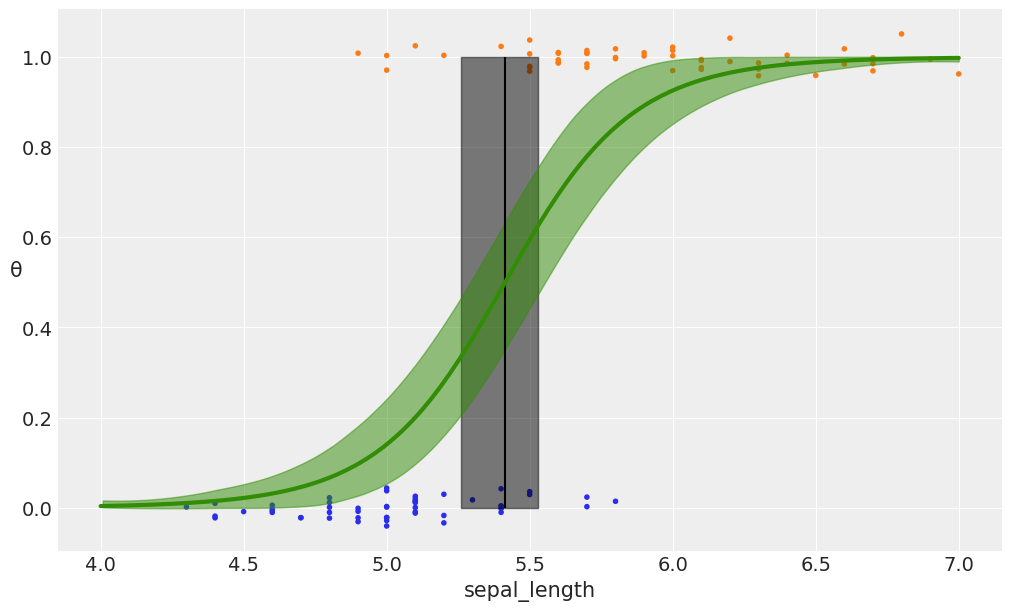

In [31]:
_, ax = plt.subplots(figsize = (10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color = [f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)
ax.vlines(db_mean, 0, 1, color = 'k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color = 'k', alpha = 0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:,0], fp, color='C2')

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

아까에 비해서 fp_mean이 조금 더 sigmoid 함수와 비슷해졌다.

### 조금 더 복잡한 모델에 적용해보기
목표 : 나이에 따라 병에 걸릴 확률은 얼마인가

In [32]:
df_sf = pd.read_csv('data/space_flu.csv')
df_sf.head()

,age,space_flu
0,49,0
1,22,0
2,10,1
3,25,1
4,79,1


[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

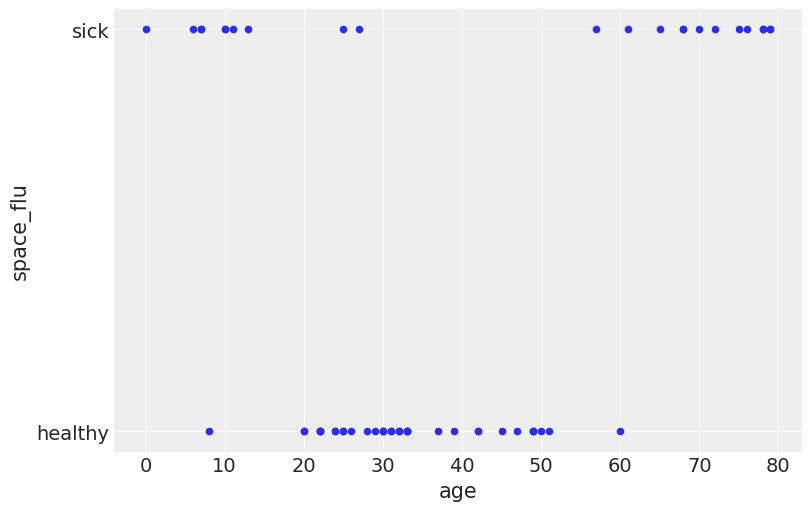

In [33]:
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu.values

ax = df_sf.plot.scatter('age', 'space_flu', figsize = (8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

In [34]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X = age)
    y_ = pm.Bernoulli('y', p = pm.math.sigmoid(f), observed = space_flu)
    idata_space_flu = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 18 seconds.


In [35]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_space_flu, var_names=['f_pred'], samples = 1000)

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0.5, 0, 'age')

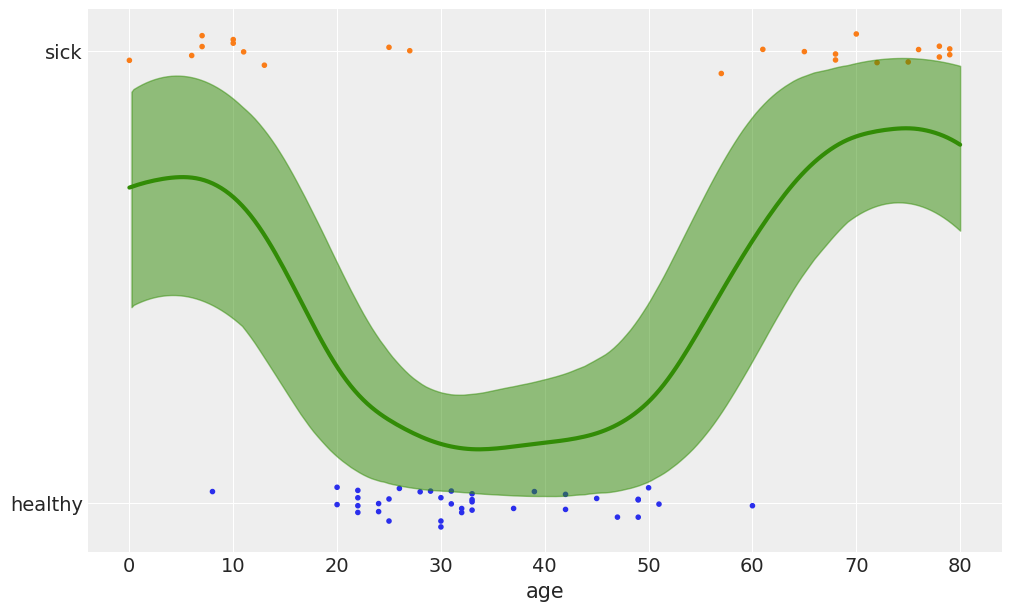

In [36]:
_, ax = plt.subplots(figsize = (10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
          marker='.', color = [f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw = 3)

az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')

## Cox Process

### Coal mining example

In [37]:
coal_df = pd.read_csv('data/coal.csv', header=None)
coal_df.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [38]:
years = int(coal_df.max().values - coal_df.min().values) # 총 year의 개수
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# 데이터에 대해 이산화 진행
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0])
x_data = x_centers[:, None]

y_data = hist / 4

In [39]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X = x_data)
    
    y_pred = pm.Poisson('y_pred', mu = pm.math.exp(f), observed = y_data)
    idata_coal = pm.sample(1000, chains=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'rate')

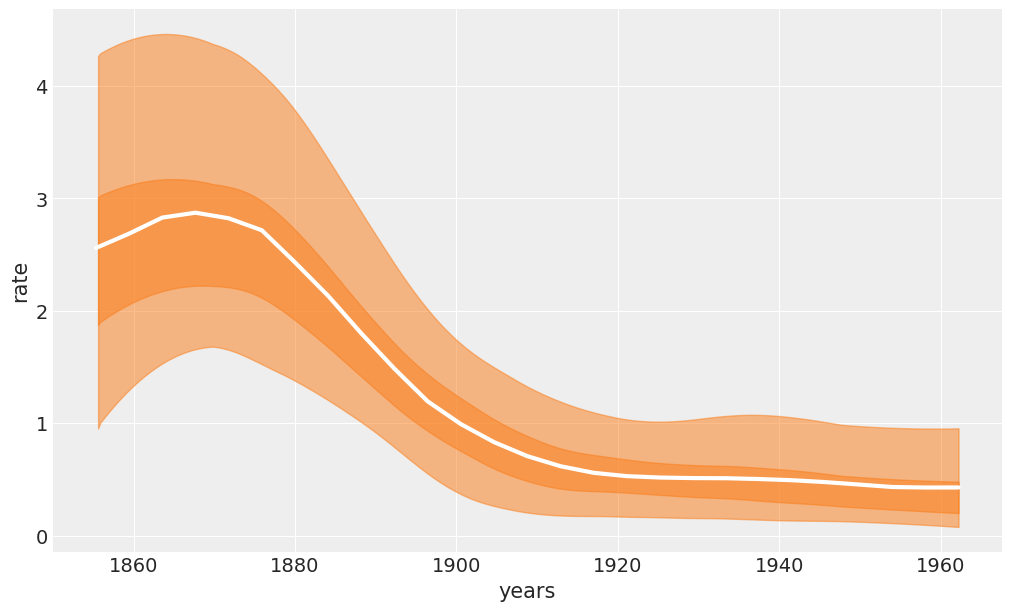

In [40]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(idata_coal.posterior['f'].stack(samples=("chain", "draw")).T)
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.set_xlabel('years')
ax.set_ylabel('rate')

### redwood data
나무의 비율이 공간에서 어떻게 퍼져있는지 보기

In [41]:
rw_df = pd.read_csv('data/redwood.csv', header=None)
rw_df.head()

,0,1
0,0.931481,0.817680
1,0.938889,0.764273
2,0.935185,0.721915
3,0.979630,0.664825
4,0.787037,0.661142


Text(0, 0.5, 'x2 coordinate')

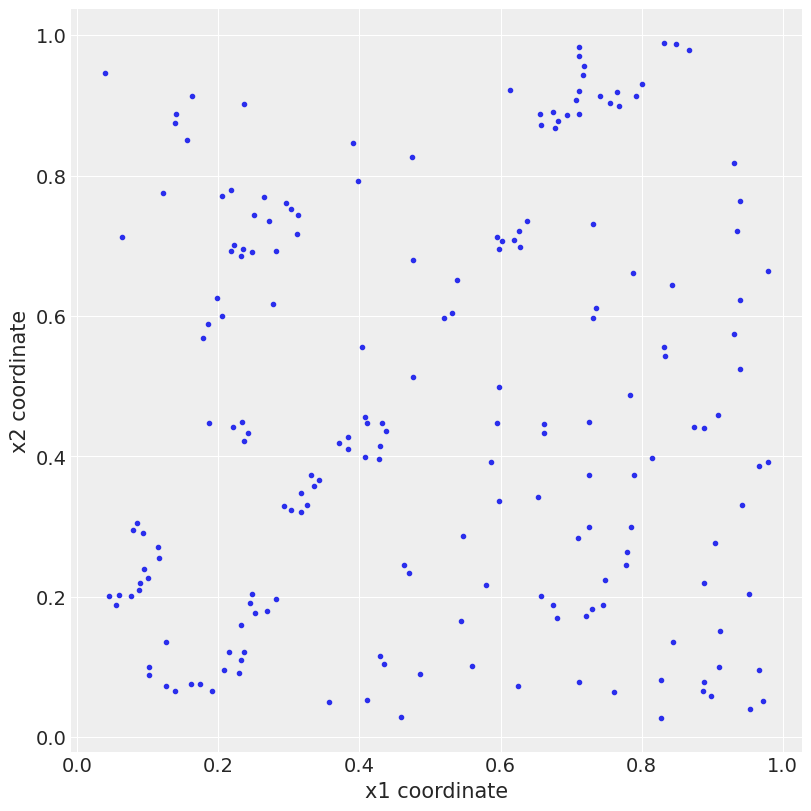

In [42]:
_, ax = plt.subplots(figsize = (8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')

In [43]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [44]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    # x1, x2가 독립이라고 가정하면 계산의 양이 훨씬 줄어든다.
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])
    
    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2]) # 2차원 형태의 Gaussian Process
    f = gp.prior('f', Xs = x_data)
    
    y = pm.Poisson('y', mu = pm.math.exp(f), observed = y_data)
    idata_rw = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ℓ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [45]:
az.summary(idata_rw, var_names=['ℓ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ[0],0.125,0.036,0.078,0.185,0.002,0.001,345.0,547.0,1.02
ℓ[1],0.094,0.027,0.053,0.144,0.002,0.001,221.0,645.0,1.01


C:\Users\User\AppData\Local\Temp\ipykernel_2972\805419180.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)


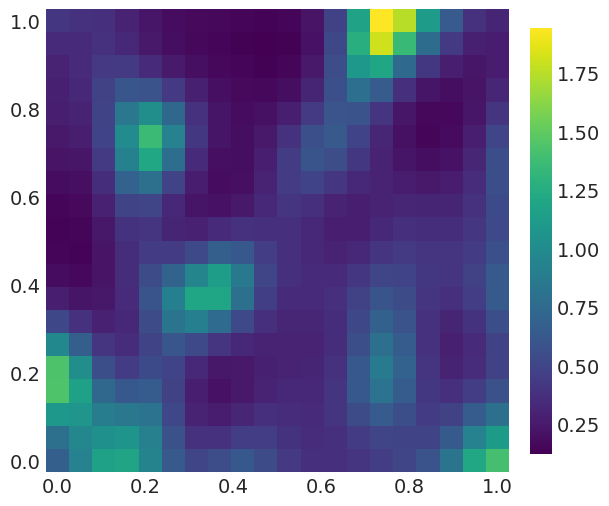

In [46]:
rate = np.exp(np.mean(idata_rw.posterior['f'].stack(samples=("chain", "draw")).T, axis=0).values.reshape((bins, -1)))
fig, ax = plt.subplots(figsize = (6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)